# Indexation accélérée

Importation des librairies nécessaires

In [1]:
from IPython.display import Video
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import clip
import pandas as pd

from PIL import Image
import ffmpeg

Pré-configuration

In [4]:
VIDEO_PATH = "../../data/tests/videos/video1.mp4"

Nous allons faire de l'indexation avec une approche légèrement différente que dans la section [Indexation](./indexing.ipynb). Nous allons nous préoccuper uniquement des images adjacentes. Nous allons itérer sur les vecteurs de caractéristiques des différentes images et calculer le dot product entre le vecteur actuel et le suivant.

De plus, nous allons remplacer l'approche ``opencv`` par l'utilisation du logiciel ``FFmpeg`` pour manipuler les vidéos.

In [5]:
heigth, width = 240, 320

probe = ffmpeg.probe(VIDEO_PATH)
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])

out, _ = (
    ffmpeg
    .input(VIDEO_PATH, loglevel="warning")
    .filter("scale", size="film")
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)

film = 352, 240
ntsc = 720, 480

width, height = film

images = (
    np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])
)

images.shape

(472, 240, 352, 3)

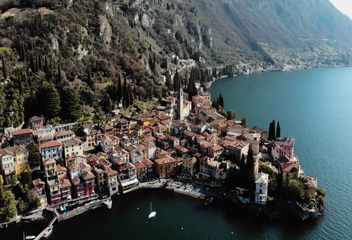

In [6]:
Image.fromarray(images[0])

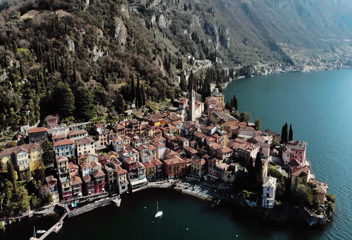

In [7]:
Image.fromarray(images[52])

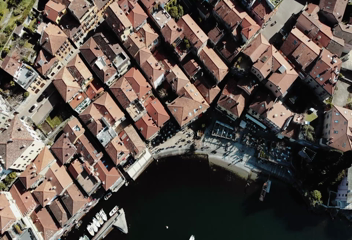

In [8]:
Image.fromarray(images[175])

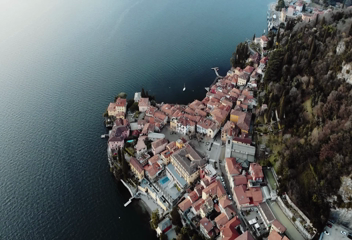

In [9]:
Image.fromarray(images[286])

## Indexation sur base de la similarité entre les images

In [10]:
model, preprocess = clip.load("ViT-B/32")
model.cpu().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int (np.prod(p.shape)) for p in model.parameters()])}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab_size:", vocab_size)

Model parameters: 151277313
Input resolution: 224
Context length: 77
Vocab_size: 49408


In [11]:
torch_images = [preprocess(Image.fromarray(image)) for image in images]
batch = torch.tensor(np.stack(torch_images)).cpu()

In [12]:
with torch.no_grad():
    image_features = model.encode_image(batch)

print(image_features.shape)
image_features /= image_features.norm(dim=1, keepdim=True)

torch.Size([472, 512])


In [15]:
slices = [0]
threshold = 0.15
for i in range(1, len(images)):
    if 1 - image_features[i-1] @ image_features[i] >= threshold:
        slices.append(i)

slices.append(len(images)+1)
print(slices)

[0, 106, 194, 473]


## Sauvegarde des résultats

In [20]:
entries = []

video_name = Path(VIDEO_PATH).stem
for i in range(len(slices) -1):
    start = slices[i]
    end = slices[i+1] - 1
    preview_name = f"{video_name}_{start}_{end}.png"

    entries.append((video_name, preview_name, start, end))

    Image.fromarray(images[slices[i]]).save("../data/tests/frames/" + preview_name)

df = pd.DataFrame(data=entries, columns=["video_name", "preview_name", "start", "end"])

In [18]:
df

,video_name,preview_name,start,end
0,video1,video1_0_105.png,0,105
1,video1,video1_106_193.png,106,193
2,video1,video1_194_472.png,194,472


In [19]:
df.to_pickle("../data/tests/index.pkl")

## Visualiser les résultats

In [21]:
FRAMES_PATH = "../data/tests/frames/"

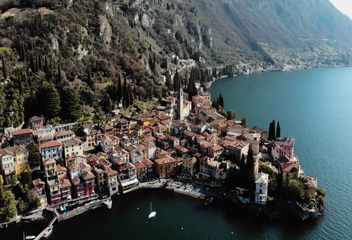

In [23]:
Image.open(FRAMES_PATH + df["preview_name"].iloc[0])

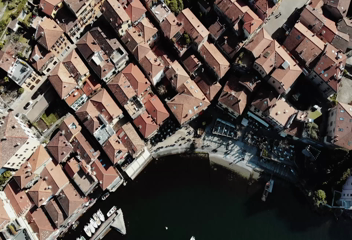

In [24]:
Image.open(FRAMES_PATH + df["preview_name"].iloc[1])

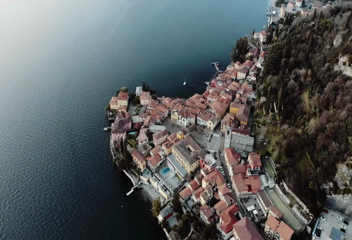

In [25]:
Image.open(FRAMES_PATH + df["preview_name"].iloc[2])